# A Feedforward Spiking Neural Network
## The following code was adapted from snnTorch tutorial 3 By Jason K. Eshraghian 

The snnTorch tutorial series is based on the following paper.

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>


In [1]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 1.4 MB/s 


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# 1. Simplifying the Leaky Integrate-and-Fire Neuron Model

## 1.1 The Decay Rate: $\beta$

## 1.2 Weighted Input Current

## 1.3 Spiking and Reset


## 1.4 Code Implementation
Implementing this neuron in Python looks like this:

In [4]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

In [5]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


Run a quick simulation to check the neuron behaves correctly in response to a step voltage input:

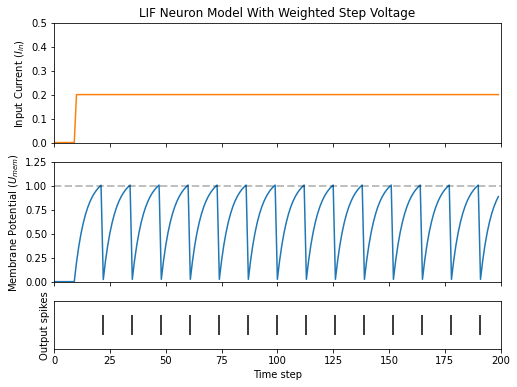

In [6]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

# 2. `Leaky` Neuron Model in snnTorch

In [7]:
lif1 = snn.Leaky(beta=0.8)

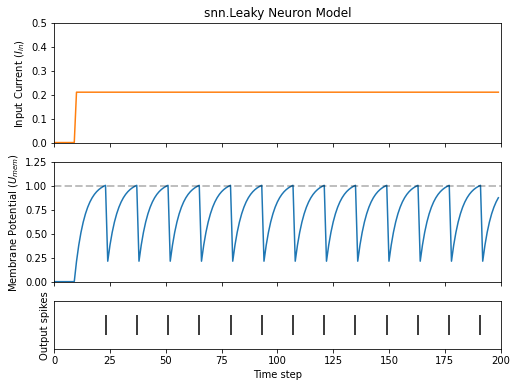

In [8]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

# 3. A Feedforward Spiking Neural Network

In [9]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [10]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

In [11]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


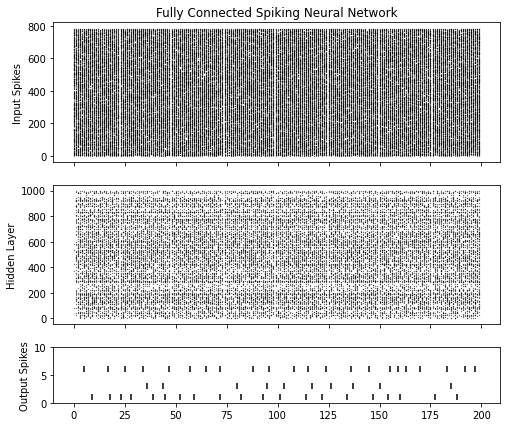

In [12]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

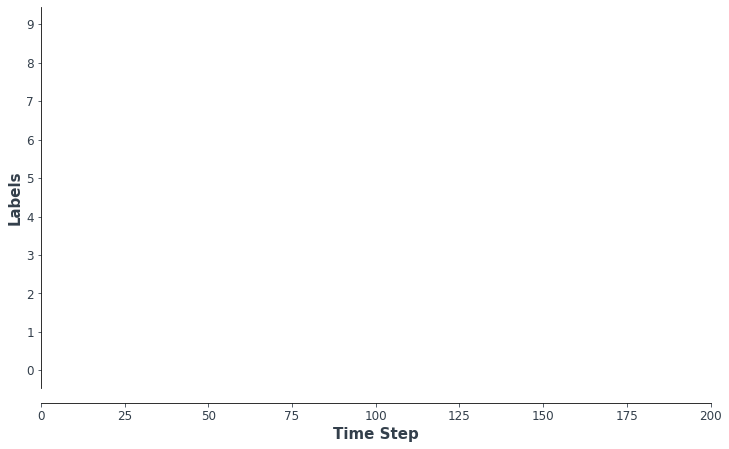

In [13]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()


#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())

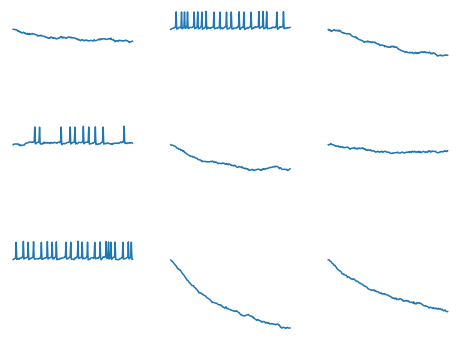

In [14]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(8, 6)